# Welcome to the accelerate python code tutorial

## This notebook has a pdf

This notebook also comes with its own pdf. You can use this pdf as a last-resort tool, when python simply won't work. The very bottom of this notebook contains some instructions for converting this notebook to pdf.

## Setting up the environment

We need some packages that do not come with standard python deployments. Either install these packages via this conda / pip commands yourself, or install the environment based on the .yaml file in this directory.

## Setting autoreload

Importing some pre-compiled cython files is similar to importing regular python files. They get appended to the current namespace and stay there even if you change the file or reload it. Let us use the autreload magic to fix that issue.

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Cython. It's compiled python.

Cython is aimed to be a superset to the python programming language. Cython is a compiled language with python-like syntax. You can write cython files (.pyx) files in a similar manner than you would write normal python files (.py), compile them and import the generated shared object (.so) as a module into your python code. Doing this allows you to greatly decrease the computational overhead at run time, i.e. make python faster. You may find the best use in cython if you use it to compile specific computationally-heavy functions.

## The compilation pipeline

Cython is always compiled in two steps.

- The cython compiler transforms cython code (.pyx) into optimized and platform-independent C or C++ code (.c).
- A standard compiler compiles the C code (.c) into a shared object (.so) which can be imported to python.

The shared object is platform specific (architecture and OS). Someone running the very niche Windows 10 for ARM will face some difficulties using your .so file. On windows these files also get a different extension (.pyd). After we get this sorted out we will look at how to write and compile cython.

## Compilation

There are several ways you can utilize to get your cython code compiled and imported into python. Here are 3:

### Distutils and Cythonize

`distutils` is a python standard package used for building, packing and distributing python projects. It can compile C source code into an extension module. How neat is that?! It manages all python versions, platforms and architectures. That's pretty neat. Cython's `cythonize()` function produces a .c file and `distutils` compiles it for us. This compilation pipeline requires us to write a short setup script. This compilation pipeline is the most common way to ditribute cython code.



**Reading and writing files in jupyter**

Instead of opening with your text editor of choice (Hint: There is a correct answer to the question "What is your favorite text editor" and emacs is not it.) let us open the .pyx files direclty in this notebook using magic. With magic I am talking about the stuff you put after the percent characters in cells. This includes line magic `%matplotlib notebook` and  cell magic `%%time`.

In [ ]:
%%time
for i in range(9):
    y = i ** i ** i

Let's use the %load magic function to open the file helloworld.pyx

In [ ]:
# %load helloworld.pyx
print(Hello World)

As you can probably guess, the quotation marks declaring 'Hello World' as a string are missing. Let's fix that using the %%writefile cell magic.

In [ ]:
%%writefile helloworld.pyx
def hello_world():
    """This is the docstring which gets transferred into the .so
    
    Additionally to printing hello world, I will also do some calculations.
    
    Args:
        No args lol.
        
    Returns:
        None
        
    """
    for i in range(9):
        y = i ** i ** i
    print("Hello World")

**The setup file**

A simple setup.py file is only a few lines long (most of them are imports). At the core you have the nested function call. The `cythonize()` function can take single files, list of files or glob patterns. The `cythonize()` function returns a list of distutils extension modules, that the setup function knows how to use. This setup.py file can be invoked from the command-line using:

```bash
$ python setup.py build_ext --inplace
```

In [ ]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("helloworld.pyx")
)

In [ ]:
!python setup.py build_ext --inplace

In [ ]:
import os
os.listdir()

You see, that some files have appeared in your current directory. The helloworld.c file contains quite a few lines C code. But after compiling it, it is faster than python.

Now we can import stuff from our shared object.

In [ ]:
from helloworld import hello_world
print(help(hello_world))

In [ ]:
hello_world()

## IPython %%cython magic

Although distutils is the quasi-standard for deploying cython code we can use ipythons %%cyhton magic to interactively work with cython. IPython handles the rest for us, translating, compiling and importing the function. This also circumvents a major draw-back when you develop cython code.

**:( :( :( :( :( :( :( :(**

Changes in .so files are not caught by the %autoreload extension, meaning if you change something in your cython code and recompile it, you have to restart the kernel.

In [9]:
%load_ext Cython

The %%cython cell magic comes with its own options, you can check out here:

https://ipython.org/ipython-doc/2/config/extensions/cythonmagic.html

In [ ]:
%%cython
def fibonacci(int n):
    cdef int i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b, a
    return a

In [ ]:
fibonacci(20)

The compiled file can be found in ~/.ipython/cython)

## On-the-fly compilation with pyximport

pyximport retrofits the import statement to recognize .pyx extension modules. The pyximport module comes with cython and can easily be accessed via:

In [ ]:
import pyximport
pyximport.install()

In [ ]:
%%writefile fib.pyx
def fibonacci(int n):
    cdef int i
    cdef double a=0.0, b=1.0
    for i in range(n):
        a, b = a+b, a
    return a

With pyximport we can now import from .pyx files. In the background there is still the compilation pipeline going on, but we don't need to worry about that.

In [ ]:
import fib

In [ ]:
print(fib.__file__)
print(type(fib))

In [ ]:
%%time
fib.fibonacci(90)

## cython and further C dependencies

The great advantage of pyximport is that it not only checks, whether the source .pyx file has been changed but also if any dependencies within that source file have been changed (regardless of any changes to the .pyx file). These dependencies are tracked in a file with the .pyxdeps extension and the same name as the base .pyx file. The file definitions in this file can also be glob patterns.

Here's an example using C:

First we define a function in lib/examples.c

In [ ]:
%%writefile lib/examples.c
#include <stdio.h>
#include <string.h>
#include "examples.h"

double fibby(const int n)
{
  int i;
  double tmp, a=0.0, b=1.0;
  for ( i = 0; i < n; i++)
  {
    tmp = a + b;
    b = a;
    a = tmp;
  }
  return a;
  // printf("Your fibonacci number is: %f\n", a);
}

The packed C library will be compiled from the examples.h header file. In the header file we need to point to the fibby function defined in examples.c

In [ ]:
%%writefile lib/examples.h
#ifndef EXAMPLES_H
#define EXAMPLES_H

double fibby(const int n);

#endif

**Create the library**

Now we create the library by either using the makefile I copied from somewhere and running:

```bash
$ cd lib/
$ make
```

or by executing this cell:

In [ ]:
%%bash
cd lib
gcc -c -fPIC examples.c examples.h # compile the source files without making them executable
# also, compilation without -c would not work, because no main function is defined in examples.c
ar rcs libexamples.a examples.o # make an archive out of the output. This archive can be imported to cython
# ls

The finished libary is in the libexamples.a file. We need a .pyx file that makes use of our fibby function. Here it is:

In [ ]:
%%writefile pyexamples.pyx
cdef extern from "examples.h":
    double fibby(const int n)

def c_wrapped_fib(n: int) -> None:
    out = fibby(n)
    print("Your fibonacci number is: ", out)

And we need a setup.py file to make distutils handle the compilation. Because we have an external dependency, we need to declare that in the setup.py file.

In [ ]:
%%writefile setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize

examples_extension = Extension(
    name="pyexamples",
    sources=["pyexamples.pyx"],
    libraries=["examples"],
    library_dirs=["lib"],
    include_dirs=["lib"]
)
setup(
    name="pyexamples",
    ext_modules=cythonize([examples_extension])
)

After executing the setup script we can use our fibby function.

In [ ]:
!python setup.py build_ext --inplace

In [ ]:
import pyexamples

In [ ]:
pyexamples.c_wrapped_fib(90)

## Do the same thing via pyximport

Pyximport can also shorten this pretty tedious task. Using pyximport, again, allows us to recompile everything anytime some changes are made to any file. For this we can use the same .pyx file already created called pyexamplex.pyx. However, we need to tell pyximport which files it needs to consider for the compilation process. Here we need to adjust the settings of distutils Extension() function. This function is added to a .pyxbld file which can be used py pyximport to get infos about all the files needed to compile that module. Let's also copy the pyxexamples.pyx file to fib_wrapped_C.pyx to get a clean slate.

In [ ]:
!cp pyexamples.pyx fib_wrapped_C.pyx

In [36]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7efd10cf32b0>)

In [ ]:
%%writefile fib_wrapped_C.pyxbld
def make_ext(modname, pyxfilename):
    from distutils.extension import Extension
    return Extension(
        name="fib_wrapped_C",
        sources=["fib_wrapped_C.pyx", "lib/examples.c"],
        include_dirs=[".", "lib"])

In [ ]:
import fib_wrapped_C

In [ ]:
fib_wrapped_C.c_wrapped_fib(90)

Let's change something in the examples.c file and see, if it has worked.

In [ ]:
%%writefile lib/examples.c
#include <stdio.h>
#include <string.h>
#include "examples.h"

double fibby(const int n)
{
  int i;
  double tmp, a=0.0, b=1.0;
  for ( i = 0; i < n; i++)
  {
    tmp = a * b; // changed to multiplication to see if pyximport is working
    b = a;
    a = tmp;
  }
  return a;
  // printf("Your fibonacci number is: %f\n", a);
}

In [ ]:
fib_wrapped_C.c_wrapped_fib(90)

I was promised, that pyximport will recognize the changes to the lib/examples.c file. Oh well. Maybe you will have more luck. ¯\\_( ツ )_/¯

# Cython compiler directives

Compiler directives are instruction that influence how cython code is compiled. They have to follow this syntax:

- Be at the very start of the file
- have a comment char '# '
- followed by 'cython:'
- multiple directives can be listed with commas

Example:

```cython
# cython nonecheck=True, boundscheck=False

cdef here_comes_a_func():
    func = lambda x" f"hello {x}"
    return func
```

A full list of compiler directives can be found here:

https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html#compiler-directives

Important directives are:

- cdivision (True/False): If set to False, cython will adjust division expressions so that the remainder of division matches python's division. This is because C rounds towards 0 and python rounds towards infinity.
  - `>>> -1 % 5
     4` in python.
  - `-1 % 5
     -1` in C and C++.
  - cdivision set to true can also lead to unexpected behavior when division by zero occurs. Because C doesn't check beforehand if a division by zero will be performed, anything from crashes to corrupted data can happen.
- infer_types (True/False): Default is None and only safe (semantically unchanging variables) inferences are allowed. E.g. Using integers for variables used in arithmetic expressions can lead to overflow. This needs to be specifically requested.
- optimize.use_switch (True/False): Whether to translate chained python if-else statements to C switch statements.

# Python and Cython performance

## Why is python slow

The main advantage of python is its platform-independence. This independence was realized by including a python virtual machine that handles the task of translating the python bytecode generated from .py files into machine code that can be executed on the CPU of your computer. This versatility makes python slower compared to compiled languages that create platform-specific machine code (gcc does not even create bytcode from the source files and goes straight to machine code).

When you call a function from within python that has been declared, translated and compiled in/from a .pyx file, the python VM skips the translation of bytecode to machine code and goes straight to the correct lines of machine code from the compiled file. The translation of python code into C code is handled by the cython module. This gives us a speedup for free. All we have to do is rename the file into .pyx and do the compilation steps.

## Dynamic and static typing

However, the speedup can be greatly improved with **static typing**. Python is a dynamically typed language. This allows us to do fun stuff like adding integers to floats:

```python
>>> print(1 + 2.1)
3.1
```

Lower level programming languages (like C) are statically typed. Every variable needs to be declared with its datatype. The speedup when using static typing comes from the compilers optimizing the machine code for that specific datatype. A simple operation like `a + b` can become quite some time intensive. The interpreter asks for the datatype of a and b, the implementation of addition for the given datatypes, and calls this function. Inside the addition function the types of the variables might be casted to different types.

We can achieve a speedup in our python code by simply typing variables statically. For this we use the `cdef` keyword followed by the variable type and name:

```cython
cdef int i
```

The difference becomes apparent with the following snippet:

In [ ]:
a = [x+1 for x in range(12)]
b = a
print(a[3], b[3])
a[3] = 42.0
print(a[3], b[3])
a = 13
print(a, b[3])

The same command `b = a` in cython would *copy* the data and yield a result akin to this:

```cython
>>> a = [x+1 for x in range(12)]
>>> b = a
>>> a[3] = 42.0
>>> print(a[3], b[3])
4 42.0
```

Static defined ctypes in cython follow C coercion and casting rules.

```C
double x, y;
x = 3;            // implicitly conversion (coercion)
y = (double) 5;   // explicitly conversion (casting)
```

Static variables in cython can be declared in many ways:

```cython
def a_func():
    cdef int i=0, j, k
    cdef float price=20.0, margin
    
def another_func():
    cdef:
        int i
        int N=2000
```

To compare the speed of dynamically and statically typed variables we need to turn off cython's own type inference, which normally assumes good types for variables. We can do this with the @cython function decorator. All variables in this function are henceforth handled as python objects.

In [ ]:
def integrate(a, b, f):
    N = 2000
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = integrate(0, 1, f)

In [ ]:
%%writefile dynamic_typed.pyx
cimport cython

@cython.infer_types(False)
def integrate(a, b, f):
    N = 2000
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
import dynamic_typed

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = dynamic_typed.integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = dynamic_typed.integrate(0, 1, f)
# print(integral)

In [ ]:
%%writefile static_typed.pyx
def integrate(a, b, f):
    cdef int i
    cdef int N=2000
    cdef float dx, s=0.0
    dx = (b-a)/N
    for i in range(N):
        s += f(a + i*dx)
    return s * dx

In [ ]:
import static_typed

In [ ]:
%%timeit
f = lambda x: x + 5 # expected integral from 0 to 1 is 0.5 + 5 = 5.5
integral = static_typed.integrate(0, 1, f)
f = lambda x: 5 + .5*x - 5*x**2 + 17*x**3 - .332*x**4 + 200*x**5 - 1000*x**6 + 0.00001*x**7# get a random polynomial
integral = static_typed.integrate(0, 1, f)
# print(integral)

## Automatic type inference

Cython can guess the types of variables automatically to make your code run faster. This is not always possible. Consider this function:

```cython
def automatic_inference():
    i = 1
    d = 2.0
    c = 3+4j
    r = i * d * c
    return r
```
Here, only the variable d is correctly set to C's double type. The rest are python objects. This slows down our code.

**Why are they python objects?**

- `i = 1` this could be `bint`, `short`, `int`, `long`. Not sure, so use python object to allow maximum compatibility.
- `c = 3+4j` could be `float complex` or `double complex`. Not sure. Use python object.
- `r = i * d * c` same here.

**Better type inference**

We can allow cython more leeway in deciding types with the same `@cython.infer_types` decorator.

```cython
cimport cython

@cython.infer_types(True)
def more_inference():
    i = 1
    d = 2.0
    c = 3+4j
    r = i * d + c
    return r
```

Now `i` is set to `long`, `d` is set to `double` and `c` and `r` are considered `double complex`. When infer_types is set to true, we have to make sure that our integers don't overflow. So make sure `i` never goes over 9223372036854775807, or you will end up with -9223372036854775808.

## Static type reference of python types

The built-in python types can also be statically defined. Here they are:

- `cdef list`
- `cdef dict`
- `cdef str`
- `cdef set`

Under the hood, cython makes these objects to C pointer to the binary data of a python `struct`. They can be used like ordinary python variables but stay constrained to their respective type.

In [ ]:
import struct
import binascii

values = (1, 'This is a string'.encode('utf-8'), 2.723)
s = struct.Struct('I 22s f') # len of str is 16 22s adds some \x00 ASCII NULLs
packed_data = s.pack(*values)
print(packed_data)

## Types of cython functions

Much of static and dynamic variables also applies to functions. C and python functions are pretty similar. Tehy have names, take zero or a number of arguments, and return new values. However, python functions are objects. They:

- have states
- can be created at import time or at runtime
- can be created anonymously (lambda)
- be returned from other functions
- passed as argument to other functions
- called with positional and keyworded arguments
- defined with default values

C functions have less overhead. They:

- can be passed as arguments to other C functions
- cannot be defined inside other functions
- their names are not modifiable
- take arguments only by position
- can't have default values

This results in python functions being orders of magnitude slower than C functions.

**First let's look at a pure python function**

In [9]:
def fact(n):
    """Computes factorial."""
    if n <= 1:
        return 1
    return n * fact(n - 1)
%timeit fact(20)

2.75 µs ± 31.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Def

**By just prepending the %%cython cell magic we can speed this function up significantly**

In [11]:
%load_ext cython

In [15]:
%%cython
def fact_cy(n):
    """Also computes factorial."""
    if n <= 1:
        return 1
    return n * fact_cy(n - 1)

In [16]:
%timeit fact_cy(20)

845 ns ± 2.44 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


### cdef

**Let's make it even faster by telling cython: Don't use dynamic python functions, use C integers and change the recursive function to a loop**

We need to wrap the c_fact() function with a small python function (wrap_c_fact()) which calls it. 

In [39]:
%%cython
cdef long c_fact(long n):
    """Computes factorial very fast."""
    if n <= 1:
        return 1
    return n * c_fact(n - 1)

def wrap_c_fact(n):
    return c_fact(n)

In [41]:
%timeit wrap_c_fact(20)

74.5 ns ± 3.81 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


**Some drawbacks:**

cdef functions are restricted to C types and thus would give erroneous results for c_fact(21) because of integer overflow.

### cpdef

cpdef functions combine the accessibility of def functions with the performance of cdef functions.
With the `inline` keyword we can tell the compiler to replace the function with its body, whenever it is called, thus removing the last bit of overhead which arises from multiple function calls. That's basically how fast it gets.

In [44]:
%%cython
cpdef inline long cp_fract(long n):
    if n <= 1:
        return 1
    return n * cp_fract(n - 1)

In [45]:
%timeit cp_fract(20)

72.3 ns ± 0.791 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


## Faster for loops

To make sure your loops in cython get converted to efficient C code use something akin to this snippet:

```cython
cdef unsigned int i, n=100
for i in range(n):
    # ...
```

Example: Running average. To get a nice fast loop and calculate a running average with it you can use something like this. Note, that we can't iterate over the elements of a, because we need the i-1 and i+1 indices as well.

```cython
cdef unsigned int i, n = len(a) - 1 # ignore the last element
for i in range(1, n): # ignore the 0th element
    a[i] = (a[i -1] + a[i] + a[i + 1]) / 3.0
```

## Compile time statements and declarations

You can use `DEF` declarations and `IF-ELIF-ELSE` statements to define recurring magic numbers or do conditional compilation:

```cython
DEF PI = 3.1416
DEF E = 2.7183

IF UNAME_SYSNAME == "Windows":
    # Run windows code
ELIF UNAME_SYSNAME == "Darwin":
    # Run Mac code
ELIF UNAME_SYSNAME == "Linux":
    # Run Linux code
ELSE:
    # Make me a spam sandwich
    
def some_func():
    return E ** PI
```

# N-body simulations

Let's start with a pure python implementation.

In [52]:
%run -p nbody.py 500000

-0.169075164
-0.169096567
 

Most of the time the program spends in the iterator.

# Organizing cython code

In normal python code is organized into packages. You have -packages for plotting (matpolotlib), or numerical caluclations (numpy). In these packages you have modules and submodules. A very common module of matplotlib is the matplotlib.pyplot module or the matplotlib.colors module. In the colors module you will find functions (rgb_to_hex) and classes (Normalize). This is how python code is organized

```python
>>> import matplotlib as mpl
>>> type(mpl.colors.Normalize)
type
>>> type(mpl.colors.rgb_to_hsv)
function
```

The same organization can be achieved with cython code. Cython modules can use functions from other cython modules. For this organization, cython has 3 filetypes. .pyx files are *implementation files*, .pxd are *definition files* and .pxi are *include files*. Together with these file extensions cython has the `cimport` statement to grant compile time access to C-level constructs. The .pxd files are searched for these constructs.

To show the inner workings of these different files we will write some code into different files. Let's say we want to do some simulations. We need a class to capture the current state. This class will be defined in a simulator.pyx file.

In [2]:
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

In [5]:
%matplotlib notebook

In [118]:
test_box = Box()

In [170]:
pos = np.random.rand(1, 3) * 20 - 10
pos[0, 0] = 101.0
pos[0, 1] = -101.0
print(pos)
new_pos = State.pbc(pos, test_box)
print((new_pos))

[[ 101.         -101.            3.26882996]]


TypeError: pbc() missing 1 required positional argument: 'box'

In [204]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class Box:
    def __init__(self):
        self.boundaries = 100
        
class LJ:
    def __init__(self):
        

class State:
    def __init__(self, positions, momenta, ns):
        # initial conditions
        self.positions = positions
        self.n_particles = positions.shape[0]
        self.momenta = momenta
        self.time = 0
        self.box = Box()
        
        # check whether positions and momenta are correcly shaped
        assert self.positions.shape == self.momenta.shape
        
        # the propagation is handled by a generator found in self._propagate()
        self.traj = self._propagate()
            
    def run_with_plot(self, n_steps):
        """Runs the sim and plots stuff."""
        self.fig, self.ax = plt.subplots()
        self.ani = animation.FuncAnimation(self.fig, func=self._update_plot,
                                           interval=5, init_func=self._plot, blit=True)
        
    def _propagate(self):
        """Uses generator to propagate the state."""
        pos = self.positions
        while True:
            pos = self.pbc(pos + self.momenta, self.box)
            t = self.time + 1
            # needs neighbour list
            # needs force calculation
            # needs momenta calculation
            yield pos, t
       
    @staticmethod
    def pbc(pos, box):
        for d in range(pos.shape[1]):
            upper_bound = box.boundaries
            lower_bound = - box.boundaries
            
            tmp_pos = pos[:, d] - upper_bound
            upper_atoms = np.where(tmp_pos > 0)
            pos[upper_atoms, d] -= (upper_bound-lower_bound)
            
            del tmp_pos, upper_atoms
            
            tmp_pos = lower_bound - pos[:, d]
            lower_atoms = np.where(tmp_pos > 0)
            pos[lower_atoms, d] += (upper_bound-lower_bound)
            
            del tmp_pos, lower_atoms
            del upper_bound, lower_bound
        return pos
            
    def update(self):
        if self.time % 
        self.positions, self.time = next(self.traj())
        
    def _update_plot(self, i):
        data, t = next(self.traj)
        # Set x and y data...
        self.scat.set_offsets(data)
        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
        
    def _plot(self):
        """Initial drawing of the scatter plot."""
        pos, t = next(self.traj)
        self.scat = self.ax.scatter(*pos.T, s=150, edgecolor="k")
        self.ax.axis([-100, 100, -100, 100])
        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

            
    def _build_str(self):
        s = ''
        s += f"Simulation at time {self.time} with {self.n_particles} particles"
        return s
        
    def __str__(self):
        return f"<{self._build_str()}>"
    
    def __repr__(self):
        return f"<{self._build_str()} at 0x{id(self):02x}>"
    
def run(State, n_steps):
    """Propagates a State for n_steps"""
    print(State.positions[0])
    for i in range(n_steps):
        State.update()
        print(State.positions[0])
            
np.random.seed(1)
positions = np.random.rand(20, 2) * 20 - 10
momenta = (np.random.rand(20, 2) * 20 - 10) / 10
sim = State(positions, momenta)
print(sim)

<Simulation at time 0 with 20 particles>


In [205]:
sim.box.boundaries

100

<IPython.core.display.Javascript object>


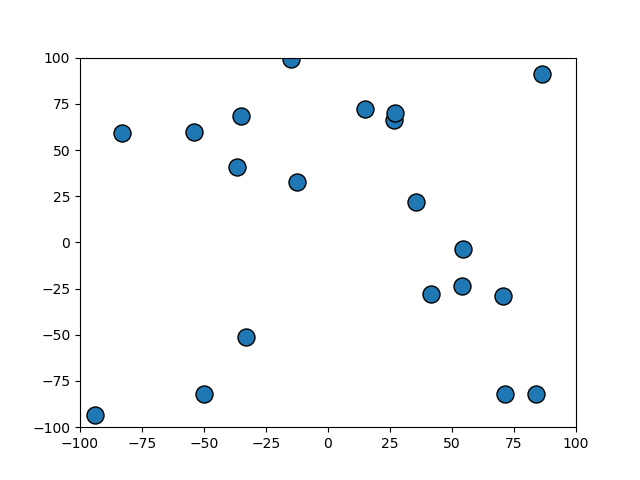

In [206]:
plt.close('all')
sim.run_with_plot(50)

In [130]:
sim.positions

array([[-1.65955991,  4.40648987],
       [-9.9977125 , -3.95334855],
       [-7.06488218, -8.1532281 ],
       ...,
       [ 5.92977734, -1.04983722],
       [-6.31744888,  6.57465703],
       [-9.3800408 ,  8.93456539]])

<IPython.core.display.Javascript object>


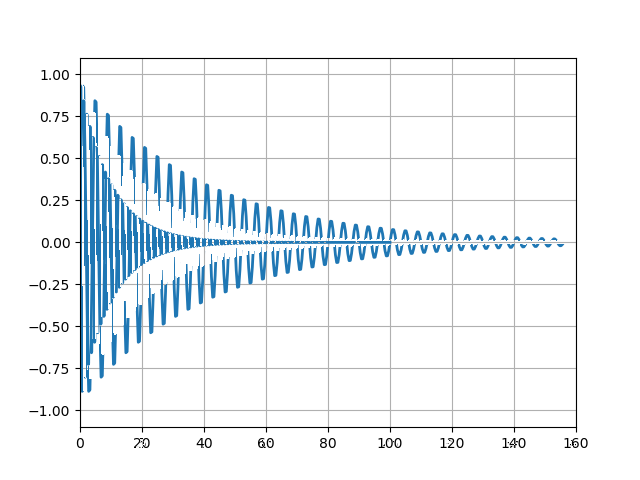

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
plt.show()

In [ ]:
%%writefile simulator.pyx
ctypedef double real_t # create the alias 'real_t' for the type 'double'

cdef class State:
    cdef:
        unsigned int n_particles
        real_t *x
        real_t *vx
        
    def __cinit__(positions)

In [3]:
a = [1, 2 ,3]
id(a)

139625768519688

In [4]:
import ctypes

In [6]:
ctypes.cast(139625768519688, ctypes.py_object).value

[1, 2, 3]

In [1]:
import array

In [ ]:
array.array()

## Python

A simple python function to print a certain number of prime numbers. I got a time of 30.7 ms ± 300 µs for for 1000 prime numbers.

In [1]:
def primes_python(nb_primes):
    if nb_primes > 1000:
        nb_primes = 1000
      
    p = list(range(100000)) # number space for checking
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
        
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

In [22]:
%%timeit
primes = primes_python(1000)

30.7 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Cython

By simply saving the function to a .pyx file and compile it with cython we can save a great amount of time.

In [23]:
%%writefile prime_numbers.pyx
def primes_cython(nb_primes):
    if nb_primes > 1000:
        nb_primes = 1000
      
    p = list(range(100000)) # number space for checking
    len_p = 0  # The current number of elements in p.
    n = 2
    
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1
        
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

Overwriting prime_numbers.pyx


In [24]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("prime_numbers.pyx")
)

Overwriting setup.py


In [25]:
!python setup.py build_ext --inplace

Compiling prime_numbers.pyx because it changed.
[1/1] Cythonizing prime_numbers.pyx
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/kevin/projects/accelerate_python_code/prime_numbers.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'prime_numbers' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -I/home/kevin/.conda/envs/work_3/include/python3.6m -c prime_numbers.c -o build/temp.linux-x86_64-3.6/prime_numbers.o
gcc -pthread -shared -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed build/temp.linux-x86_64-3.6/prime_numbers.o -L/home/kevin/.conda/envs/work_3/lib -lpython3.6m -o 

In [28]:
import os
os.listdir()

['.ipynb_checkpoints',
 'vmdscene.obj',
 'vmdscene.mtl',
 'accelerate_python_code.ipynb',
 'accelerate_python_code.pdf',
 'helloworld.pyx',
 'helloworld.c',
 'helloworld.cpython-36m-x86_64-linux-gnu.so',
 'setup.py',
 'build',
 'prime_numbers.pyx',
 'prime_numbers_cdef.pyx',
 'prime_numbers_cdef.c',
 'prime_numbers_cdef.cpython-36m-x86_64-linux-gnu.so',
 'prime_numbers.c',
 '.nfs000000000b7a973100015283',
 'prime_numbers.cpython-36m-x86_64-linux-gnu.so']

**Importing from shared objects is 

In [6]:
from prime_numbers import primes_cython

In [7]:
%%time
primes = primes_cython(1000)
print(primes[::4])

[2, 11, 23, 41, 59, 73, 97, 109, 137, 157, 179, 197, 227, 241, 269, 283, 313, 347, 367, 389, 419, 439, 461, 487, 509, 547, 571, 599, 617, 643, 661, 691, 727, 751, 773, 811, 829, 859, 883, 919, 947, 977, 1009, 1031, 1051, 1087, 1103, 1129, 1171, 1201, 1229, 1259, 1289, 1303, 1327, 1381, 1427, 1447, 1471, 1489, 1523, 1553, 1579, 1607, 1621, 1663, 1697, 1723, 1753, 1787, 1823, 1867, 1879, 1913, 1951, 1993, 2011, 2039, 2081, 2099, 2131, 2153, 2207, 2239, 2269, 2293, 2333, 2351, 2381, 2399, 2437, 2467, 2521, 2549, 2591, 2621, 2659, 2683, 2699, 2719, 2749, 2789, 2803, 2843, 2879, 2909, 2953, 2971, 3019, 3049, 3083, 3121, 3169, 3203, 3229, 3259, 3307, 3329, 3359, 3389, 3433, 3463, 3499, 3529, 3547, 3581, 3613, 3637, 3673, 3701, 3733, 3769, 3803, 3847, 3877, 3911, 3929, 3967, 4007, 4027, 4073, 4099, 4133, 4159, 4217, 4241, 4261, 4289, 4339, 4373, 4421, 4451, 4483, 4517, 4549, 4591, 4637, 4651, 4679, 4723, 4759, 4793, 4817, 4877, 4919, 4943, 4969, 4999, 5021, 5059, 5099, 5119, 5171, 5209, 5237,

## Cython with C-types

In [8]:
%%writefile prime_numbers_cdef.pyx
def primes_cython_cdef(int nb_primes):
    cdef int n, i, len_p
    cdef int p[1000]
    if nb_primes > 1000:
        nb_primes = 1000

    len_p = 0  # The current number of elements in p.
    n = 2
    while len_p < nb_primes:
        # Is n prime?
        for i in p[:len_p]:
            if n % i == 0:
                break

        # If no break occurred in the loop, we have a prime.
        else:
            p[len_p] = n
            len_p += 1
        n += 1

    # Let's return the result in a python list:
    result_as_list  = [prime for prime in p[:len_p]]
    return result_as_list

Writing prime_numbers_cdef.pyx


In [9]:
%%writefile setup.py
from distutils.core import setup
from Cython.Build import cythonize

setup(
    ext_modules = cythonize("prime_numbers_cdef.pyx")
)

Overwriting setup.py


In [10]:
!python setup.py build_ext --inplace

Compiling prime_numbers_cdef.pyx because it changed.
[1/1] Cythonizing prime_numbers_cdef.pyx
/home/kevin/.conda/envs/work_3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/kevin/projects/accelerate_python_code/prime_numbers_cdef.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'prime_numbers_cdef' extension
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -I/home/kevin/.conda/envs/work_3/include/python3.6m -c prime_numbers_cdef.c -o build/temp.linux-x86_64-3.6/prime_numbers_cdef.o
gcc -pthread -shared -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed -L/home/kevin/.conda/envs/work_3/lib -Wl,-rpath=/home/kevin/.conda/envs/work_3/lib,--no-as-needed build/temp.linux-x86_64-3.6/prime_numbers_cdef.o -L/home/kevin/.con

In [14]:
from prime_numbers_cdef import primes_cython_cdef

In [16]:
%%time
primes = primes_cython_cdef(1000)
print(primes[::4])

[2, 11, 23, 41, 59, 73, 97, 109, 137, 157, 179, 197, 227, 241, 269, 283, 313, 347, 367, 389, 419, 439, 461, 487, 509, 547, 571, 599, 617, 643, 661, 691, 727, 751, 773, 811, 829, 859, 883, 919, 947, 977, 1009, 1031, 1051, 1087, 1103, 1129, 1171, 1201, 1229, 1259, 1289, 1303, 1327, 1381, 1427, 1447, 1471, 1489, 1523, 1553, 1579, 1607, 1621, 1663, 1697, 1723, 1753, 1787, 1823, 1867, 1879, 1913, 1951, 1993, 2011, 2039, 2081, 2099, 2131, 2153, 2207, 2239, 2269, 2293, 2333, 2351, 2381, 2399, 2437, 2467, 2521, 2549, 2591, 2621, 2659, 2683, 2699, 2719, 2749, 2789, 2803, 2843, 2879, 2909, 2953, 2971, 3019, 3049, 3083, 3121, 3169, 3203, 3229, 3259, 3307, 3329, 3359, 3389, 3433, 3463, 3499, 3529, 3547, 3581, 3613, 3637, 3673, 3701, 3733, 3769, 3803, 3847, 3877, 3911, 3929, 3967, 4007, 4027, 4073, 4099, 4133, 4159, 4217, 4241, 4261, 4289, 4339, 4373, 4421, 4451, 4483, 4517, 4549, 4591, 4637, 4651, 4679, 4723, 4759, 4793, 4817, 4877, 4919, 4943, 4969, 4999, 5021, 5059, 5099, 5119, 5171, 5209, 5237,

# Reloading cython

Cython is a little bit complicated when it comes to reloading the compiled .so files.

# Import C and C++ code (chapter 7 and 8 from book)

# Convert to pdf

To build this pdf you need to have jupyter extensions installed. Either with pip:

```bash
$ pip install jupyter_contrib_nbextensions
```

or with conda:

```bash
$ conda install -c conda-forge jupyter_contrib_nbextensions
```

To convert the notebook into a pdf you can execute:

```bash
$ jupyter nbconvert --to pdf accelerate_python_code.ipynb
```

### Errors
These errors might occur when you try to convert this notebook into a pdf:

**Permissions to a shared object**

If you get an error, because python does not have permissions to some shared object execute this:

```bash
$ export LD_LIBRARY_PATH=/home/kevin/.conda/envs/work_3/lib:$LD_LIBRARY_PATH
```
**Wrong kernelspec**

If you get an error, because conda doesn't know the kernel open the notebook file in a texteditor and change the kernel name by hand.

```json
 "metadata": {
  "kernelspec": {
   "display_name": "work_3",
   "language": "python",
   "name": "nb-conda-faster_py_env-py"
```

will be changed to:

```json
 "metadata": {
  "kernelspec": {
   "display_name": "work_3",
   "language": "python",
   "name": "faster_py_env"
```

In [3]:
!jupyter nbconvert --to pdf accelerate_python_code.ipynb

[NbConvertApp] Converting notebook accelerate_python_code.ipynb to pdf
[NbConvertApp] Writing 24118 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 32661 bytes to accelerate_python_code.pdf
